<a href="https://colab.research.google.com/github/CatTastic23/CSC177-Data-Analytics-and-Mining/blob/main/nguyen_catherine_csc177_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 2: K-Means Clustering on Movies Dataset. 
**Name:** Catherine Nguyen

**Date:** Nov. 08, 2020

**Class:** CSC 177

**Link:** [MovieLens Dataset Source](https://www.kaggle.com/grouplens/movielens-20m-dataset)

####**Project Goal:** Find subgroups of movie watchers using the dataset and k-means clustering, and make some conclusions

1. Pick out 2 genres to focus on (for example, adventure and comedy). 
Identify clusters of movie watchers within those two genres. People who really like both types of movies, one but not the other, etc. 
2. After finishing your clustering, come up with some analysis: imagine that you are a Netflix-type service, and want to help your users find movies they like better. 
3. How would you use your clustering results to serve this purpose, or improve your business in general?

####**Project Requirements:** 
* Pick 2 different genre pairs to compare, cluster, and write some conclusions about.
* Use k-means clustering.
* Use the knee method (also known as elbow method) to determine your number of clusters.
* Document your steps using pandas/numpy/sklearn as you prepare dataframes and use them so it's easy to follow your methodology.

---
#Basic Preparation of Imports and Retrieving Dataset:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cdist

%matplotlib inline

In [ ]:
movie = pd.read_csv('/content/data/movie.csv')
rating = pd.read_csv('/content/data/rating.csv')

In [ ]:
movie.tail()

,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


In [ ]:
rating.tail()

,userId,movieId,rating,timestamp
3316811,22676,92259,3.5,2012-05-20 20:00:29
3316812,22676,93265,5.0,2012-05-16 16:28:55
3316813,22676,93297,5.0,2012-05-16 16:29:41
3316814,22676,94480,3.0,2012-05-20 19:41:35
3316815,22677,69,2.0,2002-0


**Overview of Data we are dealing with:**

In [ ]:
total_movies = movie.shape[0]
unique_movies = len(movie.movieId.unique())
total_user_ratings = rating.shape[0]
unique_users = len(rating.userId.unique())

print("Total number of movies =", total_movies)
print("Total number of unique movies =", unique_movies)
print("")
print("Total number of user ratings =", total_user_ratings)
print("Total number of unique users =", unique_users)

Total number of movies = 27278
Total number of unique movies = 27278

Total number of user ratings = 2889014
Total number of unique users = 19590


##Analysis: 
**movie:** 
* **movieID** - each movie has an unique ID number starting with 1
* **title** - holds the name of the movie and the year it was produced '(____)'
* **genres** - each genre is divided by '|'

**rating:**
* **userId** - each user has their own unique user ID because user can have multiple reviews for diff movies. 
* **movieId** - each review has a corresponding movieID to reference the movie in the movie dataset. 
* **rating** - is the numeric rating that specific user gave that specific movie. min-max [0.0,5.0]



##Cleaning Data
* Basic Procedure to ensure no NaNs affect my data analysis. 

In [ ]:
movie.dropna(inplace=True)
rating.dropna(inplace=True)
drop_movies = len(movie.movieId.unique())
drop_user_ratings = rating.shape[0]
drop_unique_users = len(rating.userId.unique())

print("total movies dropped =", (total_movies-drop_movies))
print("total user ratings dropped =", (total_user_ratings-drop_user_ratings))
print("total users dropped =", (unique_users-drop_unique_users))

total movies dropped = 0
total user ratings dropped = 1
total users dropped = 0


It seems as though none of the data was dropped from either of the dataframes. Meaning there will be zero NaNs to deal with. 

---
#Animation vs. Comedy

##Taking a look at the Movie Genres

Prior to picking the genres. I wanted to get a look at all the possible movie genres first. To do that we need to split elements in movies.genres and gather all the unique genres into a list. 
* ```.stack()``` reshapes the dataframe. from cols into rows
* ```.split()``` seperates the string
* ```.tolist()``` changes the information into a list.
* ```.unique()``` returns all the unique elements

In [ ]:
g = pd.DataFrame(movie.genres.str.split('|').tolist()).stack().unique()
g

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

The above has an array like format. This is because data lets turn it into a table. 

In [ ]:
g = pd.DataFrame(g, columns = {'genre'})
g.head()

,genre
0,Adventure
1,Animation
2,Children
3,Comedy
4,Fantasy


Now its time to merge the movies with the corresponding user rating based on the matching ```movieId```
* ```.merge()``` combines data on common/matching columns or indices

In [ ]:
rating_genres = rating.merge(movie, on='movieId')
rating_genres.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2.0,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,5,2.0,3.0,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy
2,13,2.0,3.0,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy
3,29,2.0,3.0,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy
4,34,2.0,3.0,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy


##The two genres chosen is Animation and Comedy.
Now that the DataFrames have been merged. We use this information to create a new DataFrame to be our genres rating per user. 
* To do this we start by making a list of movies for each genre. 
* Then make a list of all ratings and keep only ones that have a movie that is in the list of movies in that chosen genre. 
* With this list of ratings in just one genre, average out all ratings per user. 
* Concatenate all these user ratings per genre into the genre ratings DataFrame.

In [ ]:
# There are 138493 unique users. 
userIds = rating['userId'].unique()
userIds.shape

(2605,)

In [ ]:
userIds

array([   1,    2,    3, ..., 2603, 2604, 2605])

'''userIds''' = an np array with all unique user ids. 

##Comedy
```.str.contains()``` searches for strings that contain 'Comedy'.

```.isin()``` returns those that are in/is in. 

In [ ]:
comedy_movies = movie[movie['genres'].str.contains('Comedy')]
comedy_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
6,7,Sabrina (1995),Comedy|Romance
...,...,...,...
27270,131248,Brother Bear 2 (2006),Adventure|Animation|Children|Comedy|Fantasy
27271,131250,No More School (2000),Comedy
27272,131252,Forklift Driver Klaus: The First Day on the Jo...,Comedy|Horror
27273,131254,Kein Bund für's Leben (2007),Comedy


**There are a total of 8374 out of 27278 movies in the 'Comedy' genre**

In [ ]:
comedy_ratings = rating[rating['movieId'].isin(comedy_movies['movieId'])]
comedy_ratings

,userId,movieId,rating,timestamp
5,1,112,3.5,2004-09-10 03:09:00
7,1,223,4.0,2005-04-02 23:46:13
11,1,296,4.0,2005-04-02 23:32:47
14,1,367,3.5,2005-04-02 23:53:00
23,1,1079,4.0,2004-09-10 03:07:45
...,...,...,...,...
20000250,138493,59725,3.0,2009-10-17 22:21:18
20000251,138493,59784,5.0,2009-10-17 22:01:41
20000253,138493,60816,4.5,2009-12-03 18:32:43
20000256,138493,66762,4.5,2009-10-17 18:50:08


**There are a total of 7502234 out of 20000263 user ratings that correspond with 'Comedy' movies.**

In [ ]:
user_comedy_ratings = comedy_ratings.loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean()
user_comedy_ratings.head()

userId
1    3.731707
2    3.900000
3    4.057692
4    3.545455
5    4.083333
Name: rating, dtype: float64

**The above calculates the average rating per user for movies in the 'Comedy' genre.**

##**Animation**

In [ ]:
animation_movies = movie[movie['genres'].str.contains('Animation')]
animation_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
12,13,Balto (1995),Adventure|Animation|Children
47,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
236,239,"Goofy Movie, A (1995)",Animation|Children|Comedy|Romance
241,244,Gumby: The Movie (1995),Animation|Children
...,...,...,...
27241,131132,Kleines Arschloch - Der Film (1997),Animation|Comedy
27247,131144,Werner - Das muss kesseln!!! (1996),Animation|Comedy
27248,131146,Werner - Volles Rooäää (1999),Animation|Comedy
27269,131243,Werner - Gekotzt wird später (2003),Animation|Comedy


**There are a total of 1027 out of 27278 movies in the 'Animation' genre.** 

Thats 8 times less than the Comedy genre. 

In [ ]:
animation_ratings = rating[rating['movieId'].isin(animation_movies['movieId'])]
animation_ratings

,userId,movieId,rating,timestamp
64,1,1920,3.5,2005-04-02 23:54:58
71,1,2138,4.0,2005-04-02 23:49:49
89,1,2761,3.0,2005-04-02 23:32:39
98,1,3000,3.5,2005-04-02 23:29:29
119,1,4306,4.0,2004-09-10 03:09:44
...,...,...,...,...
20000251,138493,59784,5.0,2009-10-17 22:01:41
20000252,138493,60069,4.0,2009-11-13 17:51:27
20000254,138493,61160,4.0,2009-11-16 16:55:37
20000258,138493,68954,4.5,2009-11-13 15:42:00


**There are a total of 1140476 out of 20000263 user ratings that correspond with 'Animation' movies.**

7 times less than the 'Comedy' genre

In [ ]:
user_animation_ratings = animation_ratings.loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean()
user_animation_ratings.head()

userId
1    3.650000
2    3.000000
3    3.750000
4    4.000000
5    4.666667
Name: rating, dtype: float64

**The above calculates the average rating per user for movies in the 'Animation' genre.**

##Time to Merge: Comedy & Animation

We start by creating a new dataframe called ```genre_ratings``` which uses the np array ```usersIds``` data, it holds all the unique user ids. We this created above. The title of the first column is 'userIds'.

In [ ]:
genre_ratings = pd.DataFrame(userIds, columns=['userId'])
genre_ratings.head()

,userId
0,1
1,2
2,3
3,4
4,5


Now that we have our DataFrame set up with userIds. It is time to add the corresponding average reviews by genres 'Comedy' and 'Animation per useriD. 

In [ ]:
genre_ratings = genre_ratings.merge(user_comedy_ratings, on='userId')
genre_ratings = genre_ratings.merge(user_animation_ratings, on='userId')

genre_ratings.columns = {'userId','Animation', 'Comedy'}
genre_ratings.rename(columns = {'Comedy':'userId', 'Animation':'Comedy', 
                              'userId':'Animation'}, inplace = True) 
genre_ratings

,userId,Comedy,Animation
0,1,3.731707,3.650000
1,2,3.900000,3.000000
2,3,4.057692,3.750000
3,4,3.545455,4.000000
4,5,4.083333,4.666667
...,...,...,...
118669,138488,2.600000,2.800000
118670,138489,3.636364,4.500000
118671,138491,2.650000,2.500000
118672,138492,4.037736,3.625000


**There are 118674 unique users that have reviewed both Animation and Comedy movie genres**

I had to mess around with the order of the column names because they were not matching up correctly for some reason. 
* Had to use the ```rename()``` function. 

##Removing any NaNs/ NaNs Check to prevent Data Analysis problems:

In [ ]:
len(genre_ratings) - genre_ratings.count()

userId       0
Comedy       0
Animation    0
dtype: int64

---
#Clustering

Now that we have the appropriate data to advance us to the next step, its time to start clustering. Lets start with plotting the data and see what it looks like. 

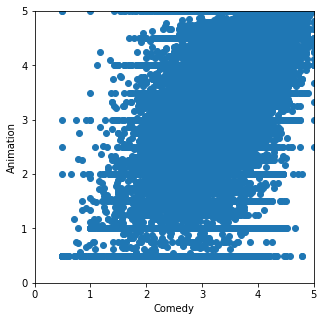

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.xlim(0,5)
plt.ylim(0,5)
ax.set_xlabel('Comedy')
ax.set_ylabel('Animation')
ax.scatter(genre_ratings['Comedy'], genre_ratings['Animation'])

We set the figure size to 5 x 5 because the max rating a movie can recieve is 5 and the lowest being 0. This is also why the limits on the x and y labels are set from 0-5. 
* One thing to note is this data is really huge so I am not surprised that its so clumped up. 
* Also, the majority of the plots are frequently found in th center and move toward the upper right corner. 

##Using K-Means on the data. 

Using ```concat```, we will cluster these values up using Kmeans and the Knee method. Below we create two graphs. One with two clusters and the other having three clusters. 

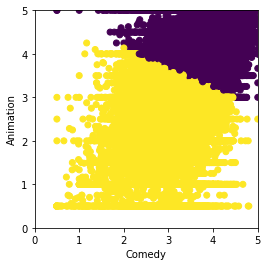

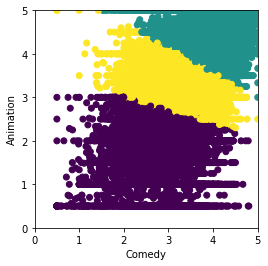

In [ ]:
X = genre_ratings[['Comedy', 'Animation']].values

for x in [2, 3]:
  #Creates an instance of KMeans to find clusters for x in [2,3]:
  kmeans = KMeans(n_clusters = x)
  #use fit_predict to cluster the dataset. based on the values of 'Comedy' and 'Animation
  prediction = kmeans.fit_predict(X)
  fig = plt.figure(figsize=(4,4))
  ax = fig.add_subplot(111)
  plt.xlim(0,5)
  plt.ylim(0,5)
  ax.set_xlabel('Comedy')
  ax.set_ylabel('Animation')

  clustered = pd.concat([genre_ratings.reset_index(), pd.DataFrame({'group':prediction})], axis=1)

  ax.scatter(genre_ratings['Comedy'], genre_ratings['Animation'], c=clustered['group'], cmap='viridis')
                                                                                             #'viridis'             

###Clustering with K = 2 and K = 3 Analysis:
* When K = 2 it just seems at those its separaredt bases on 4-5 ratings and everything else. So those who really like it then everything else. 
When K = 3, its seperated into 3 categories. both genre is rated High, Average, or Low. 

##Knee Method aka Elbow Method
Due the graphs given at k = [2,3] arent as specifically helpful. We can use another method to determine which value K should be through the knee method aka elbow method. 

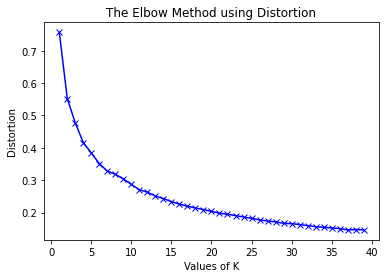

In [ ]:
X = genre_ratings[['Comedy', 'Animation']].values
distortions = []
mapping = {}
K = range(1,40)
for k in K:
  kmeans = KMeans(n_clusters = k)
  kmeans.fit_predict(X)
  distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])
  mapping[k] = sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

###Elbow/Knee Method Analysis:#
* **I can conclude that it looks ambiguous, but I am going with 11 or 12 for k**

##K-Means Clustering using the K given from the Knee Method which is 11 or 12 

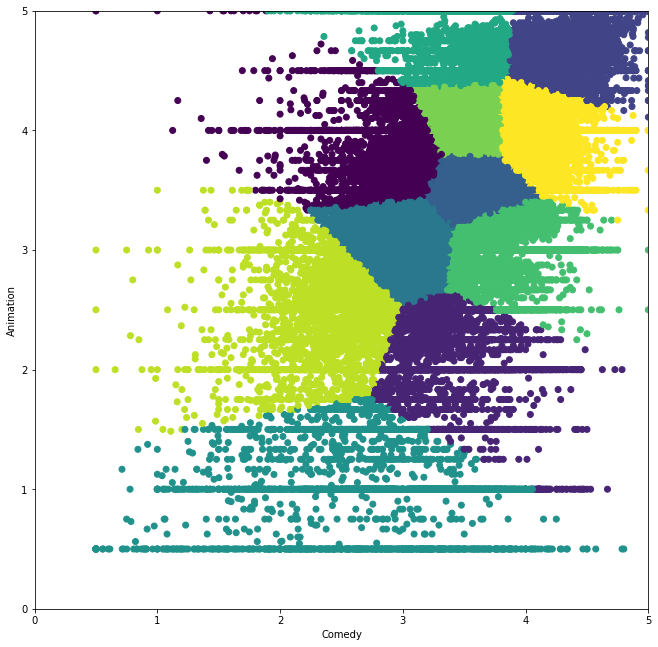

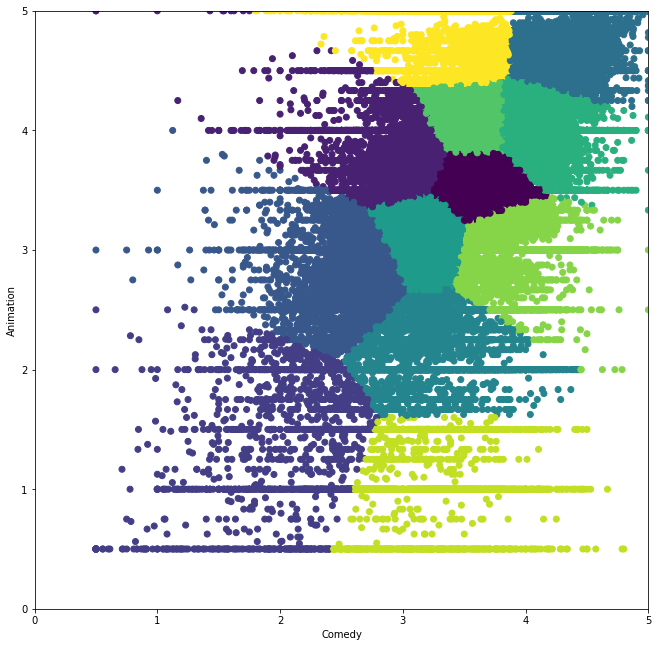

In [ ]:
X = genre_ratings[['Comedy', 'Animation']].values

for x in [11, 12]:
  #Creates an instance of KMeans to find clusters for x in [2,3]:
  kmeans = KMeans(n_clusters = x)
  #use fit_predict to cluster the dataset. based on the values of 'Comedy' and 'Animation
  prediction = kmeans.fit_predict(X)
  fig = plt.figure(figsize=(11,11))
  ax = fig.add_subplot(111)
  plt.xlim(0,5)
  plt.ylim(0,5)
  ax.set_xlabel('Comedy')
  ax.set_ylabel('Animation')

  clustered = pd.concat([genre_ratings.reset_index(), pd.DataFrame({'group':prediction})], axis=1)

  ax.scatter(genre_ratings['Comedy'], genre_ratings['Animation'], c=clustered['group'], cmap='viridis')

### K=11 and K=12 Analysis:
* I find myself enjoying the way K=12 looks more than I do K=11. This is because it does a great job clustering the inner group and the outer groups, leaving the outer groups with outliers but we can clean that up in the next step.  

##Cleaning up the outliers aka the opinionated user ratings

To do this we need to set some standards for the data we want to use. In this case making sure user ratings for the chosen genres meet the requirement of a rating of 3 or more. 

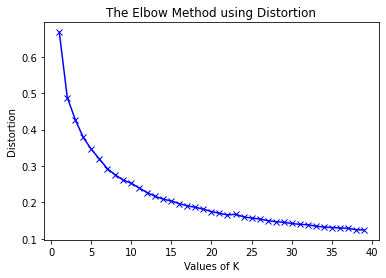

In [ ]:
opinionated_users = genre_ratings[(genre_ratings['Comedy'] > 3) | (genre_ratings['Animation'] > 3)]

X = opinionated_users[['Comedy', 'Animation']].values

distortions = []
mapping = {}

K = range(1,40)

for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit_predict(X)

  distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])

  mapping[k] = sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

**Again K=12 seems like the best based from the Knee Method.**

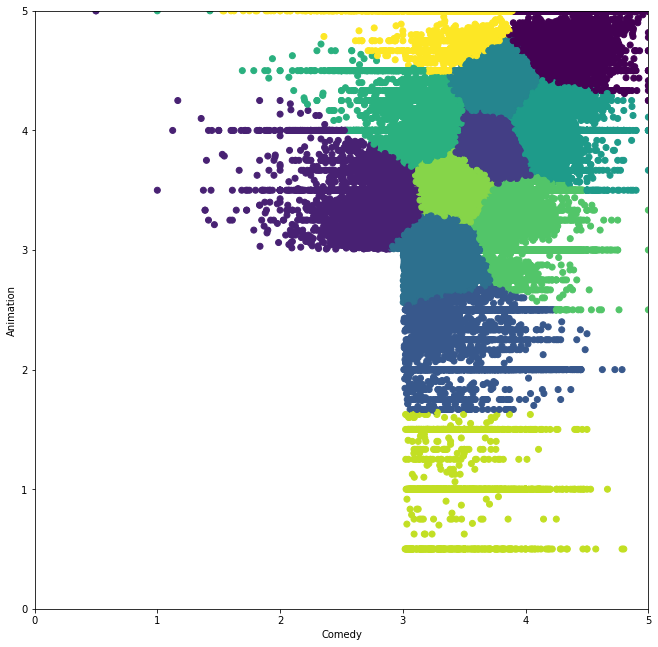

In [ ]:
X = opinionated_users[['Comedy', 'Animation']].values

for x in [12]:
  #Creates an instance of KMeans to find clusters for x in [2,3]:
  kmeans = KMeans(n_clusters = x)
  #use fit_predict to cluster the dataset. based on the values of 'Comedy' and 'Animation
  prediction = kmeans.fit_predict(X)
  fig = plt.figure(figsize=(11,11))
  ax = fig.add_subplot(111)
  plt.xlim(0,5)
  plt.ylim(0,5)
  ax.set_xlabel('Comedy')
  ax.set_ylabel('Animation')

  clustered = pd.concat([opinionated_users.reset_index(), pd.DataFrame({'group':prediction})], axis=1)

  ax.scatter(opinionated_users['Comedy'], opinionated_users['Animation'], c=clustered['group'], cmap='viridis')

###Opinionated Removal and Identifying ClustersAnalysis:
Again it seems like K = 12 is the best according to the knee method. After these groupings have been made we have enough information to conduct some analysisL
1. On the right side of the graph are users who love Comedies more than Animations.
2. On the top side of the graph are the users who love Animations more than Comedies.
3. The central groups are averages, in a sense that the users love for Comedies and Animations are proportional and as the groupings get closer to the upper right corner the higher in ratings are from those user. Which means they love both Genres equally.   

---
#Overiew/Conclusions:
1. After finishing your clustering, come up with some analysis: imagine that you are a Netflix-type service, and want to help your users find movies they like better.
2. How would you use your clustering results to serve this purpose, or improve your business in general?

1. Netflix Services: Recommendations based on Matching Genres
* As a netflix-type service I would add more genres into the mix and based on the genres they liked find the top rated movies in those genres and display it for them when they open the app.  

2. Clustering Results equate to Recommendations based on other user ratings:
* Also you can you can use collaborative filtering to get an idea of which user have the same preference of movies and use the movies they have watching to reccomend to another user. 
* This improves your busincess because it keep your users interested and curious of the next new show that will show up on their recommendations. 
* In most cases I enjoy seeing all the top movies on Netflix, they peak my curiosity because if there one of the top movies it must be good. Same fors for the other reccomendations because there hidden gems I wouldnt have been able to find without this service.
* This gives the user a sense of appeal. Which in my opion is great because not only does it attract new users, but it also retains current users by keeping then intrigued at all times. Increased user activity and decreased potentially in cancelling their subscriptions. 

##1. Netflix Service - Popularity Recommenders

In [ ]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(rating, movie[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.tail

Ran out of RAM. :( Would of loved to add more code and analysis but the RAM prevents me. Hopefully but worded answers above is enough. 

##2. Collaborative Filtering - Clusters